# RNN Name Classification

In [2]:
import math
import re
import random

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from datautils.serve import DataServer

from tqdm import tqdm_notebook

from torch.utils.data import Dataset

from datautils.vocabulary import Vocabulary
from datautils.misc import get_sequence_lengths

import six

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (14, 6)

%matplotlib inline

## Constants

In [3]:
class constants:
    NAMES_TRAIN = '/research/data/names/names_train.csv'
    NAMES_TEST = '/research/data/names/names_test.csv'
    CHAR_START_TOKEN = "^"
    CHAR_END_TOKEN= "_"

## Text Dataset

In [4]:
class NamesDataset(object):
    def __init__(self, data_path, delimiter=","):
        self.data = pd.read_csv(data_path, delimiter=delimiter)
        
    def get_data(self, nationality=None):
        data = self.data
        if nationality:
            data = self.data[self.data['label']==nationality]
        return data['name'].values, data['label'].values
    

class NamesVectorizer(object):
    def __init__(self, chars_vocab, targets_vocab, max_sequence_length):
        self.chars_vocab = chars_vocab
        self.targets_vocab = targets_vocab
        self.max_sequence_length = max_sequence_length

    @classmethod
    def induce_from_text(cls, text, targets):
        """
        A TextDataset is converted to a VectorizedDataset created by:
            1. For each variable, mapping the words or characters to an integer
            2. For each variable, packing the integers into a matrix large
                enough to contain the longest sequence for that variable
        :param text_dataset:
        :type text_dataset:
        """
        chars_vocab = Vocabulary(use_unks=True,
                                 use_start_end=True,
                                 start_token=constants.CHAR_START_TOKEN,
                                 end_token=constants.CHAR_END_TOKEN)
        
        targets_vocab = Vocabulary(use_unks=False,
                                   use_start_end=False)
        
        for character_sequence in text:
            chars_vocab.add_many(set(character_sequence))

        targets_vocab.add_many(targets)

        # add two for the start, end tokens
        max_sequence_length = 2 + max(len(character_sequence) for character_sequence in text)

        return cls(chars_vocab, targets_vocab, max_sequence_length)

    def convert_dataset(self, char_sequences, targets):
        num_data = len(char_sequences)
        x_seq = np.zeros((num_data, self.max_sequence_length), dtype=np.int64)
        y_target = np.zeros((num_data), dtype=np.int64)

        for seq_i, target in enumerate(targets):
            y_target[seq_i] = self.targets_vocab[target]

        for seq_i, char_seq in enumerate(char_sequences):
            converted_seq = list(self.chars_vocab.map(char_seq, include_start_end=True))
            x_seq[seq_i, :len(converted_seq)] = converted_seq

        return VectorizedSingleIODataset(x_seq, y_target)
        
    def save(self, filename):
        vec_dict = {"chars_vocab": vectorizer.chars_vocab.get_serializable_contents(),
                    "targets_vocab": vectorizer.targets_vocab.get_serializable_contents(),
                    "max_sequence_length": vectorizer.max_sequence_length()}

        with open(filename, "w") as fp:
            json.dump(vec_dict, fp)
        
    @classmethod
    def load(cls, filename):
        with open(filename, "r") as fp:
            vec_dict = json.load(fp)

        vec_dict["chars_vocab"] = Vocabulary.deserialize_from_contents(vec_dict["chars_vocab"])
        vec_dict["targets_vocab"] = Vocabulary.deserialize_from_contents(vec_dict["targets_vocab"])
        return cls(**vec_dict)
        
class VectorizedSingleIODataset(Dataset):
    def __init__(self, x_input, y_target):
        self.x_input = x_input
        self.y_target = y_target
        self.class_weights = 1 / np.bincount(self.y_target)

    def __len__(self):
        return len(self.x_input)

    def __getitem__(self, index):
        return {'x_input': self.x_input[index],
                'y_target': self.y_target[index], 
                'class_weights': self.class_weights,
                'x_seq_lengths': len(self.x_input[index].nonzero()[0])}
    

## Model

In [5]:
class NamesClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, input_vocab_size, output_vocab_size, num_rnn_layers=1):
        super(NamesClassifier, self).__init__()
        
        self.emb = nn.Embedding(input_vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True, num_layers=num_rnn_layers)
        self.affine = nn.Linear(hidden_dim, output_vocab_size)
        
        self._cached_config = dict(embedding_dim=embedding_dim, 
                                   hidden_dim=hidden_dim,
                                   input_vocab_size=input_vocab_size,
                                   output_vocab_size=output_vocab_size,
                                   num_rnn_layers=num_rnn_layers)
    
    def forward(self, x_in, sequence_lengths=None, apply_softmax=False, use_gpu=True):
        x_embedded = self.emb(x_in)
        x_post_rnn, _ = self.rnn(x_embedded)
        
        if sequence_lengths is not None:
            last_item_indices = sequence_lengths.data - 1
            last_item_indices += torch.arange(0, x_in.size(0)).long().cuda() * x_in.size(1)
            if use_gpu:
                last_item_indices = last_item_indices.cuda()
                x_post_rnn = x_post_rnn.contiguous().cuda()
            else:
                x_post_rnn = x_post_rnn.contiguous()
            # size = (batch, feature_size)
            x_post_rnn = x_post_rnn.view(x_in.size(0) * x_in.size(1), -1)[last_item_indices]
        else:
            x_post_rnn = x_post_rnn[:, -1, :] 
        out = self.affine(x_post_rnn)
        if apply_softmax:
            out = F.softmax(out)
        return out
    
    def save(self, json_filename, model_state_filename):
        torch.save(self.state_dict(), model_state_filename)
        with open(json_filename, "w") as fp:
            json.dump(self._cached_config, fp)
    
    @classmethod
    def load(cls, json_filename, model_state_filename):
        with open(json_filename, "r") as fp:
            config = json.load(fp)
        out = cls(**config)
        out.load_state_dict(model_sstate_filename)
        return out

In [6]:
def accuracy(yhat, ytrue):
        pred = yhat.max(1)[1].type_as(ytrue)
        correct = pred.eq(ytrue)
        if not hasattr(correct, 'mean'):
            correct = correct.cpu()
        return correct.float().mean()

In [7]:
class CrossEntTrainer(object):
    def __init__(self, model, optimizer_class, gpu_mode=False, learning_rate=0.0001, class_weights=None):
        self.model = model
        if isinstance(optimizer_class, six.string_types):
            if not hasattr(torch.optim, optimizer_class):
                raise Exception("{} is not a valid optimizer".format(optimizer_class))
            optimizer_class = getattr(torch.optim, optimizer_class)
        self.optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        
        if class_weights is not None and isinstance(class_weights, np.ndarray):
            class_weights = torch.FloatTensor(class_weights)
        
        self.loss = nn.CrossEntropyLoss(weight=class_weights)
        self.gpu_mode = gpu_mode
        self.loss_history = []
        self.accuracy_history = []
    
    def _reset_gradient(self):
        self.optimizer.zero_grad()
        self.model.zero_grad()
        
    def train(self, data_server, batch_size=64, num_batches=-1, num_epochs=1):
        if self.gpu_mode:
            self.model.cuda()
            data_server.enable_gpu_mode()
            self.loss.cuda()
        else:
            self.model.cpu()
            data_server.disable_gpu_mode()
            self.loss.cpu()
        epoch_bar = tqdm_notebook(total=num_epochs, unit=" epochs", position=0)
        batch_bar = tqdm_notebook(unit=" batches", position=1)
        for _ in range(num_epochs):
            for batch in data_server.serve_batches(batch_size, num_batches):
                self._reset_gradient()
                yhat = self.model(batch['x_input'], 
                                  sequence_lengths=batch['x_seq_lengths'],
                                  use_gpu=self.gpu_mode)
                computed_loss = self.loss(yhat, batch['y_target'])
                computed_loss.backward()
                self.optimizer.step()

                computed_loss_ = computed_loss.data.cpu().numpy()[0]
                computed_accuracy = accuracy(yhat, batch['y_target']).data.cpu().numpy()[0]
                
                batch_bar.set_postfix(loss=computed_loss_, accuracy=computed_accuracy)
                
                self.loss_history.append(computed_loss_)
                self.accuracy_history.append(computed_accuracy)
                
                batch_bar.update(1)
                
            epoch_bar.update(1)

        batch_bar.clear()
        
        
    def evaluate(self, data_server, batch_size=64):
        if self.gpu_mode:
            self.model.cuda()
            data_server.enable_gpu_mode()
            self.loss.cuda()
        else:
            self.model.cpu()
            data_server.disable_gpu_mode()
            self.loss.cpu()
        batch_bar = tqdm_notebook(unit=" batches", position=0)
        
        self.model.train(False)
        for batch in data_server.serve_batches(batch_size):
            yhat = self.model(batch['x_input'], 
                              sequence_lengths=batch['x_seq_lengths'],
                              use_gpu=self.gpu_mode)
            

            computed_loss_ = float(computed_loss.data.cpu().numpy()[0])
            batch_bar.set_postfix(loss=computed_loss_)
            self.loss_history.append(computed_loss_)
            batch_bar.update(1)
        self.model.train(True)
        batch_bar.clear()

In [8]:
train_dataset = NamesDataset(constants.NAMES_TRAIN)
train_names, train_targets = train_dataset.get_data()

test_dataset = NamesDataset(constants.NAMES_TEST)
test_names, test_targets = test_dataset.get_data()

vectorizer = NamesVectorizer.induce_from_text(list(train_names) + list(test_names), 
                                              list(train_targets) + list(test_targets))

vectorized_train = vectorizer.convert_dataset(train_names, train_targets)
train_server = DataServer(vectorized_train)

vectorized_test = vectorizer.convert_dataset(test_names, test_targets)
test_server = DataServer(vectorized_test)

In [9]:
model_parameters = dict(embedding_dim=100, 
                        hidden_dim=200,
                        num_rnn_layers=1)
model = NamesClassifier(input_vocab_size=len(vectorizer.chars_vocab),
                        output_vocab_size=len(vectorizer.targets_vocab),
                        **model_parameters)
data_server = DataServer(vectorized_train)

In [ ]:
model.save(json_filename="names_charnn_classifer.json", model_state_filename="names_charnn_classifier.state")

In [10]:
trainer = CrossEntTrainer(model, optimizer_class="Adam", gpu_mode=True, 
                          class_weights=vectorized_train.class_weights)

In [ ]:
try:
    trainer.train(data_server, num_epochs=4000, batch_size=128)
except KeyboardInterrupt:
    pass

In [35]:
sns.set_context("poster")
sns.set_style("dark", {'axes.facecolor':'0.94'})

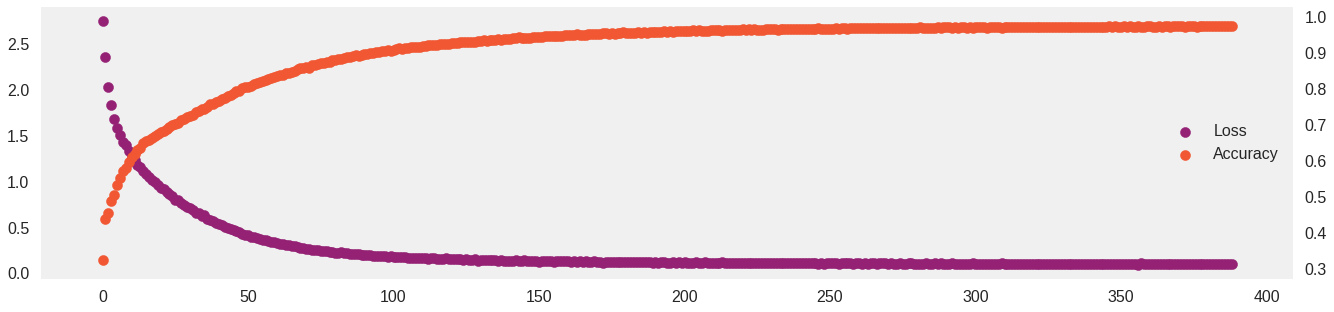

In [99]:
average_step = 200

_, ax = plt.subplots(1, 1, figsize=(20,5))

loss_history = trainer.loss_history[:len(trainer.loss_history)//average_step*average_step]
acc_history = trainer.accuracy_history[:len(trainer.accuracy_history)//average_step*average_step]

loss_history = np.array(loss_history).reshape(-1, average_step).mean(axis=-1)
acc_history = np.array(acc_history).reshape(-1, average_step).mean(axis=-1)


loss_artist = ax.scatter(np.arange(len(loss_history)), 
                         loss_history, color='#942174', 
                         s=1+average_step//2, label="Loss");

ax2 = ax.twinx()
acc_artist = ax2.scatter(np.arange(len(acc_history)), 
                         acc_history, color='#F05732', 
                         s=1+average_step//2, label="Accuracy");
artists = [loss_artist, acc_artist]
labels = [artist.get_label() for artist in artists]
plt.legend(artists, labels, loc=5)


In [71]:
def variable_from_string(vectorizer, a_string):
    out = np.array(list(vectorizer.chars_vocab.map(a_string, include_start_end=True)))
    return Variable(torch.LongTensor(out)).view(1,-1)

def prediction_vector_from_name(name):
    return model(variable_from_string(vectorizer, name).cuda(), 
                 Variable(torch.LongTensor([len(name)+2]).cuda()), 
                 apply_softmax=True)

def prediction_string_from_name(name):
    return vectorizer.targets_vocab.lookup(prediction_vector_from_name(name).max(1)[1].data[0][0])


for name, target in zip(train_names[:100], train_targets[:100]):
    pred = prediction_string_from_name(name)
    print("{:<20} predicted to be {:^10} but is {}".format(name, pred, target))

Hadad                predicted to be   Arabic   but is Arabic
Prikazchikov         predicted to be  Russian   but is Russian
Bajov                predicted to be  Russian   but is Russian
Awduewsky            predicted to be  Russian   but is Russian
Jablochkov           predicted to be  Russian   but is Russian
Panek                predicted to be   Czech    but is Czech
Imnadze              predicted to be  Russian   but is Russian
Kinashita            predicted to be  Japanese  but is Japanese
Mahortov             predicted to be  Russian   but is Russian
Kenyon               predicted to be  English   but is English
Jenkin               predicted to be  English   but is English
Prolubnikov          predicted to be  Russian   but is Russian
Groshev              predicted to be  Russian   but is Russian
Avdakoff             predicted to be  Russian   but is Russian
Woodley              predicted to be  English   but is English
Tsytovich            predicted to be  Russian   but is Ru

In [47]:
prediction_string_from_name("O'Reilly")

'Irish'

In [48]:
prediction_string_from_name("Lopez")

'Spanish'

In [49]:
prediction_string_from_name("Shakir")

'Arabic'

In [50]:
prediction_string_from_name("Mustafa")

'Arabic'

In [55]:
prediction_string_from_name("Bond")

'English'

In [59]:
prediction_string_from_name("Choi")

'Korean'

In [100]:
eval_df = {"name": [], "predicted": [], "actual": []}

for name, target in zip(test_names, test_targets):
    eval_df['name'].append(name)
    eval_df['predicted'].append(prediction_string_from_name(name))
    eval_df['actual'].append(target)
    
eval_df = pd.DataFrame(eval_df)

sum(eval_df['predicted']==eval_df['actual']) / len(eval_df)

0.79028642590286424

In [101]:
test_dataset_v2 = NamesDataset(data_path="/research/data/names/names_test_delip_version.csv", delimiter="\t")
test_names_v2, test_targets_v2 = test_dataset_v2.get_data()

eval_df = {"name": [], "predicted": [], "actual": []}

for name, target in zip(test_names_v2, test_targets_v2):
    eval_df['name'].append(name)
    eval_df['predicted'].append(prediction_string_from_name(name))
    eval_df['actual'].append(target)
    
eval_df = pd.DataFrame(eval_df)

sum(eval_df['predicted']==eval_df['actual']) / len(eval_df)

0.90833030192797382